# Supervised

This notebook trains a classification model with all the labeled images from data_augmentation.ipynb

### Imports

In [3]:
import os
import sys
import itertools
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers


from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score

from tensorflow.keras import regularizers
from itertools import product

### Definitions

In [4]:
sys.path.insert(0, "../../")
from config import RESULTS_PATH, CROPPED_PATH, MODELS_PATH

# Paths
TRAIN_PATH = os.path.join(CROPPED_PATH, 'ina', 'labeled_images', 'VGG16_agglomerative_v0', 'train')
VALIDATION_PATH = os.path.join(CROPPED_PATH, 'ina', 'labeled_images', 'VGG16_agglomerative_v0', 'validation')
TEST_PATH = os.path.join(CROPPED_PATH, 'ina', 'labeled_images', 'test')
ENCODER_PATH = os.path.join(MODELS_PATH, 'encoder', 'encoder_SSIM_MAE_Bparams.keras')
RESULT_PATH = os.path.join(RESULTS_PATH, 'results_encoder_SSIM+MAE.xlsx')
MODEL_PATH = os.path.join(MODELS_PATH, 'supervised')

# Configuration
SHAPE = (128,128,1)
BATCH_SIZE = 32
TRAIN_ENCODER = False
COLOR_MODE="grayscale"
results = []


### Functions

In [5]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)


def plot_conf_matrix(model, generator, titulo='Confusion matrix'):
    ### RETRIVE TEST LABEL FROM GENERATOR ###
    test_num = sum(1 for _ in generator)
    label_test = []
    pred_test = []

    for i, batch in enumerate(generator):
        X, y = batch
        label_test.append(y.numpy())
        predictions = model.predict(X)
        predictions = tf.nn.softmax(predictions, axis=-1)
        pred_test.append(predictions)


    label_test = np.argmax(np.vstack(label_test), axis=1)


    ### COMPUTE PREDICTIONS ON TEST DATA ###
    pred_test = np.argmax(np.vstack(pred_test), axis=1)
    accuracy=accuracy_score(label_test, pred_test)
    recall=recall_score(label_test, pred_test,pos_label=0)
    specificity=recall_score(label_test, pred_test,pos_label=1)
    precision = precision_score(label_test, pred_test, pos_label=0)
    # pred_test = pred_test[:label_test.shape[0],]
    ### ACCURACY ON TEST DATA ###
    print("-" * 40)
    print('ACCURACY:', accuracy)
    print('RECALL:',recall)
    print('PRECISION:', precision)
    print('SPECIFICITY:',specificity)
    print("-" * 40)
    print("\n")
    ### CONFUSION MATRIX ON TEST DATA ###
    cnf_matrix = confusion_matrix(label_test, pred_test)
    results.append({'Model': titulo, 'Accuracy': accuracy , 'Recall':recall,'Precision':precision,'Specificity':specificity})

    plt.figure(figsize=(7,7))
    plot_confusion_matrix(cnf_matrix, classes=['cell', 'not'], title=titulo)
    plt.title(titulo)
    plt.show()


def get_model(pretrain_encoder,TRAIN_ENCODER,input_shape,dropout_rate, l2_reg):
    encoder=pretrain_encoder

    inp = keras.Input(shape=input_shape)
    x = inp

    encoder.trainable = TRAIN_ENCODER

    x = encoder(x)

    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    out =layers.Dense(2, activation='linear')(x)


    model = keras.Model(inp, out)

    return model

### Load datasets

In [6]:
# data generator function
def data_gen ():
    train_generator = tf.keras.utils.image_dataset_from_directory(
        TRAIN_PATH,
        labels="inferred",
        label_mode="categorical",
        batch_size=BATCH_SIZE,
        image_size=(SHAPE[0], SHAPE[1]),
        color_mode=COLOR_MODE,
        shuffle=True,
        seed=42
    )
    train_generator = train_generator.map(
        lambda x, y: (x/255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    train_generator = train_generator.prefetch(buffer_size=tf.data.AUTOTUNE)


    validation_generator = tf.keras.utils.image_dataset_from_directory(
        VALIDATION_PATH,
        labels="inferred",
        label_mode="categorical",
        batch_size=BATCH_SIZE,
        image_size=(SHAPE[0], SHAPE[1]),
        color_mode=COLOR_MODE,
        shuffle=True,
        seed=42
    )
    validation_generator = validation_generator.map(
        lambda x, y: (x / 255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    validation_generator = validation_generator.prefetch(buffer_size=tf.data.AUTOTUNE)



    test_generator = tf.keras.utils.image_dataset_from_directory(
        TEST_PATH,
        labels="inferred",
        label_mode="categorical",
        batch_size=BATCH_SIZE,
        image_size=(SHAPE[0], SHAPE[1]),
        color_mode=COLOR_MODE,
        shuffle=True,
        seed=42
    )
    test_generator = test_generator.map(
        lambda x, y: (x / 255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    test_generator = test_generator.prefetch(buffer_size=tf.data.AUTOTUNE)


    return train_generator,validation_generator,test_generator


Found 14000 files belonging to 2 classes.
(32, 128, 128, 1)
(32, 2)


I0000 00:00:1746568861.697035   55820 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21327 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


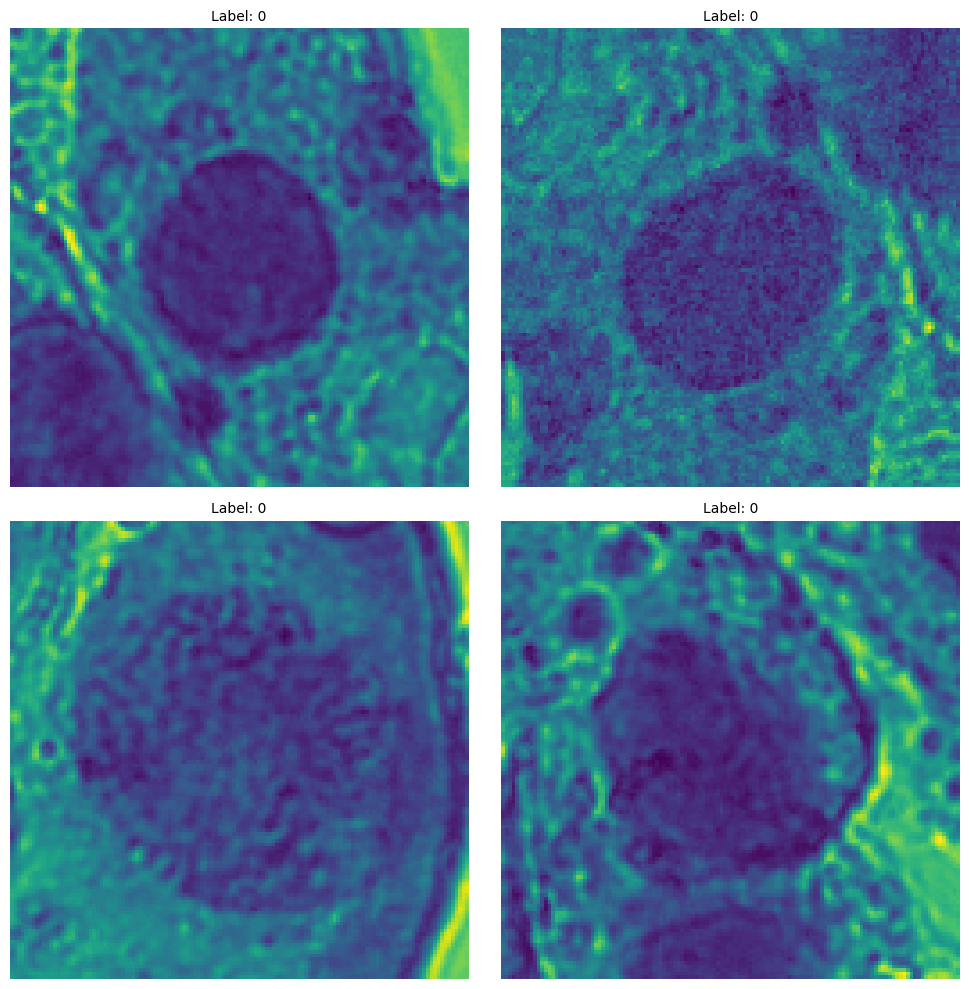

In [7]:
# plot images
train_generator = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=(SHAPE[0], SHAPE[1]),
    color_mode=COLOR_MODE,
    shuffle=False,
)



for images, labels in train_generator:
    print(images.shape)
    print(labels.shape)

    #filenames_in_batch = [train_generator.filenames[idx] for idx in train_generator.index_array]

    plt.figure(figsize=(10, 10))

    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))

        #file_name = filenames_in_batch[i]
        label = np.argmax(labels[i])
        plt.title(f"Label: {label}", fontsize=10)

        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break

In [8]:
train_generator.class_names

['cells', 'not']

### Train model

Found 14000 files belonging to 2 classes.
Found 6693 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Epoch 1/50


I0000 00:00:1746568863.712581   56463 service.cc:152] XLA service 0x32509500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746568863.712597   56463 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-05-06 19:01:03.756830: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746568863.934031   56463 cuda_dnn.cc:529] Loaded cuDNN version 90701


 70/438 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5220 - loss: 0.9105

I0000 00:00:1746568865.256887   56463 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5578 - loss: 0.7973 - val_accuracy: 0.7166 - val_loss: 0.6354
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6343 - loss: 0.6723 - val_accuracy: 0.7494 - val_loss: 0.5808
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6800 - loss: 0.6377 - val_accuracy: 0.7499 - val_loss: 0.5615
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6956 - loss: 0.6163 - val_accuracy: 0.7559 - val_loss: 0.5508
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7040 - loss: 0.6054 - val_accuracy: 0.7575 - val_loss: 0.5438
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7061 - loss: 0.6031 - val_accuracy: 0.7560 - val_loss: 0.5432
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7159 - loss: 0.5941 - val_accuracy: 0.7600 - val_loss: 0.5374
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7076 - loss: 0.5939 - val_accuracy: 0.7584 - val_

2025-05-06 19:02:05.300093: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

2025-05-06 19:02:13.425306: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


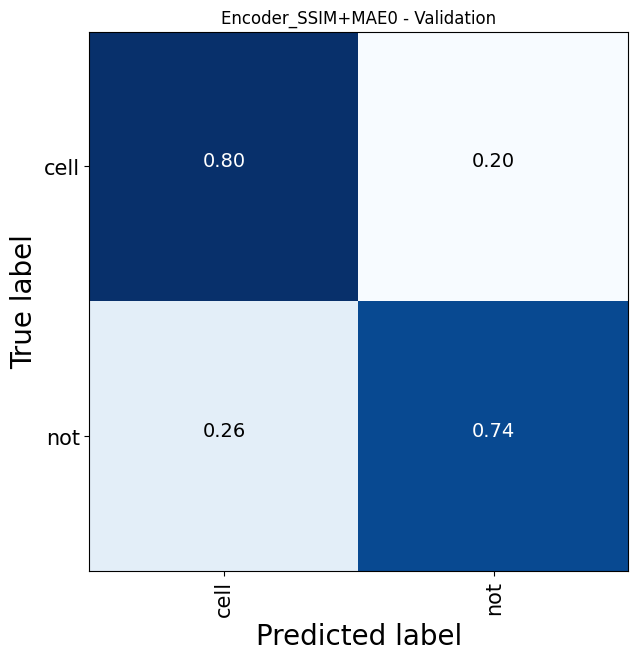

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

2025-05-06 19:02:16.153597: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


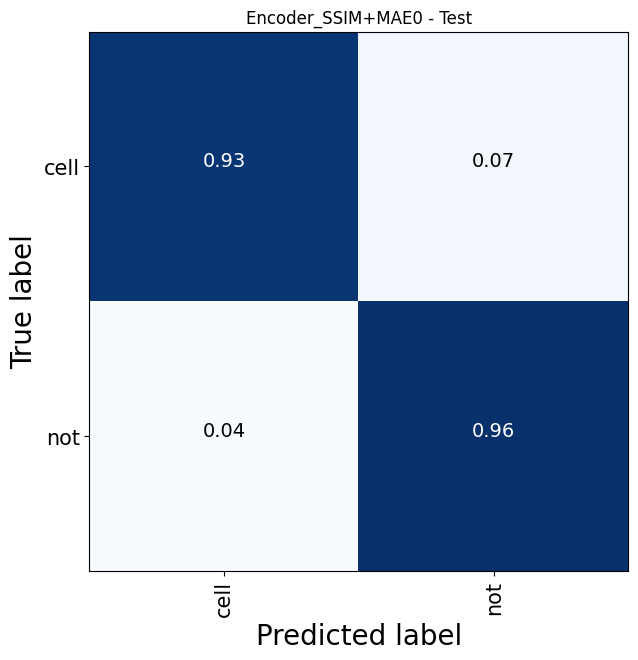

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5006 - loss: 1.1750 - val_accuracy: 0.5580 - val_loss: 0.8919
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5936 - loss: 0.8617 - val_accuracy: 0.7257 - val_loss: 0.7138
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6871 - loss: 0.7138 - val_accuracy: 0.7539 - val_loss: 0.6051
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6950 - loss: 0.6495 - val_accuracy: 0.7541 - val_loss: 0.5652
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7128 - loss: 0.6097 - val_accuracy: 0.7554 - val_loss: 0.5466
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7171 - loss: 0.5967 - val_accuracy: 0.7590 - val_loss: 0.5357
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7175 - loss: 0.5792 - val_accuracy: 0.7533 - val_loss: 0.5323
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7227 - loss: 0.5806 - val_accuracy: 0.

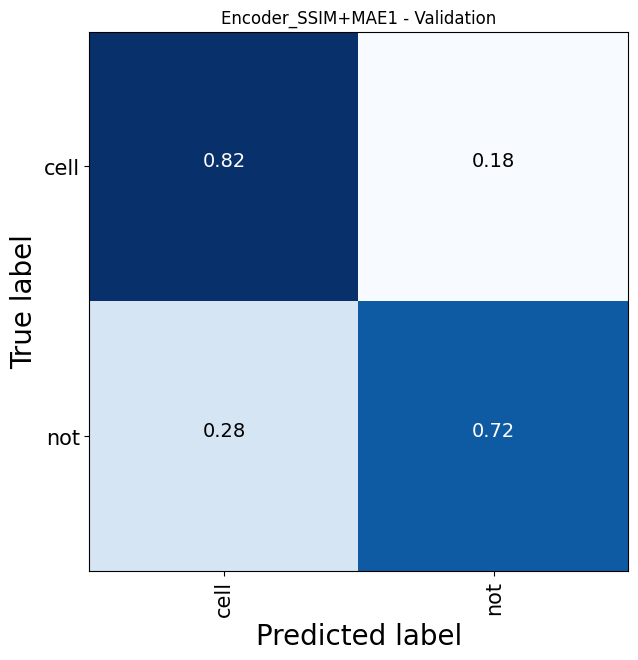

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

2025-05-06 19:03:02.336512: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


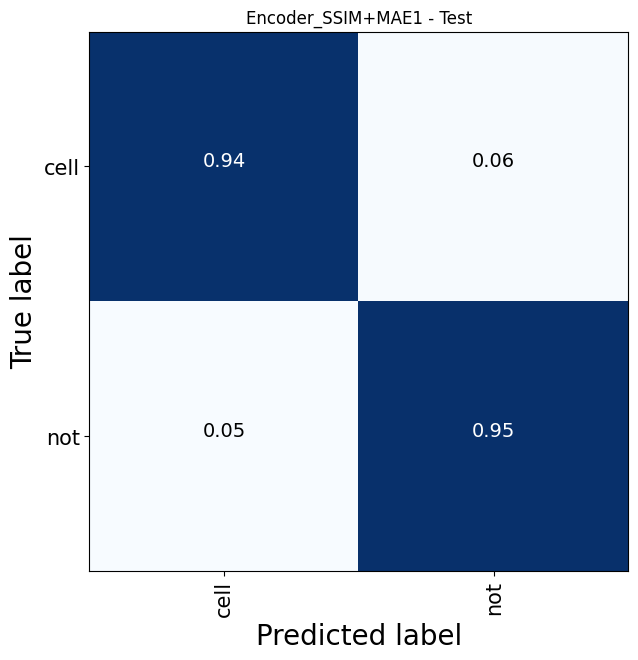

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5169 - loss: 0.8765 - val_accuracy: 0.5537 - val_loss: 0.7015
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5473 - loss: 0.7286 - val_accuracy: 0.6069 - val_loss: 0.6912
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5713 - loss: 0.7095 - val_accuracy: 0.6768 - val_loss: 0.6541
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6007 - loss: 0.6924 - val_accuracy: 0.6964 - val_loss: 0.6273
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6258 - loss: 0.6787 - val_accuracy: 0.7211 - val_loss: 0.6001
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6540 - loss: 0.6594 - val_accuracy: 0.7360 - val_loss: 0.5898
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6593 - loss: 0.6521 - val_accuracy: 0.7408 - val_loss: 0.5753
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6718 - loss: 0.6409 - val_accuracy: 0.

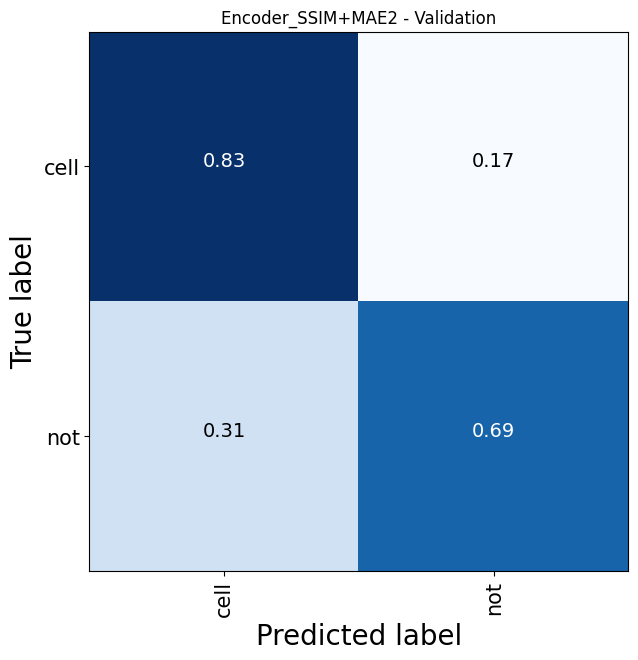

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

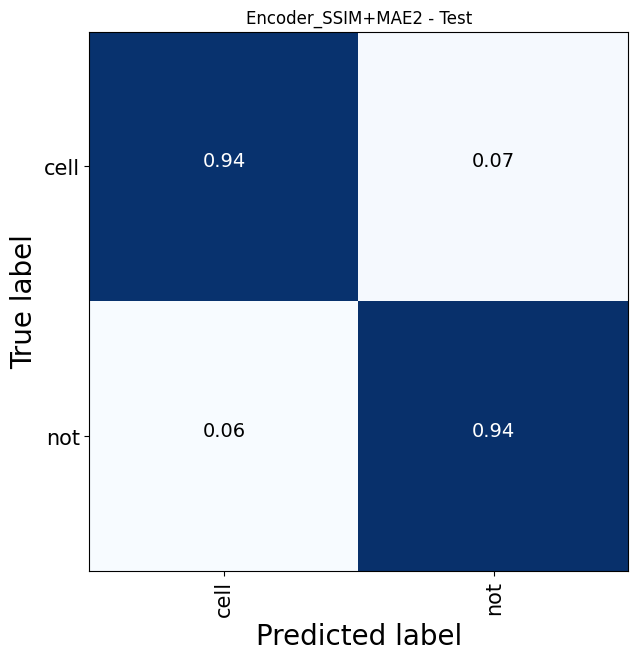

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4843 - loss: 1.2919 - val_accuracy: 0.5312 - val_loss: 0.9229
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5421 - loss: 0.8936 - val_accuracy: 0.6703 - val_loss: 0.8038
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6029 - loss: 0.7826 - val_accuracy: 0.7181 - val_loss: 0.6941
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6396 - loss: 0.7071 - val_accuracy: 0.7414 - val_loss: 0.6160
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6683 - loss: 0.6573 - val_accuracy: 0.7447 - val_loss: 0.5867
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6741 - loss: 0.6381 - val_accuracy: 0.7488 - val_loss: 0.5673
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6793 - loss: 0.6227 - val_accuracy: 0.7571 - val_loss: 0.5575
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6887 - loss: 0.6140 - val_accuracy: 0.

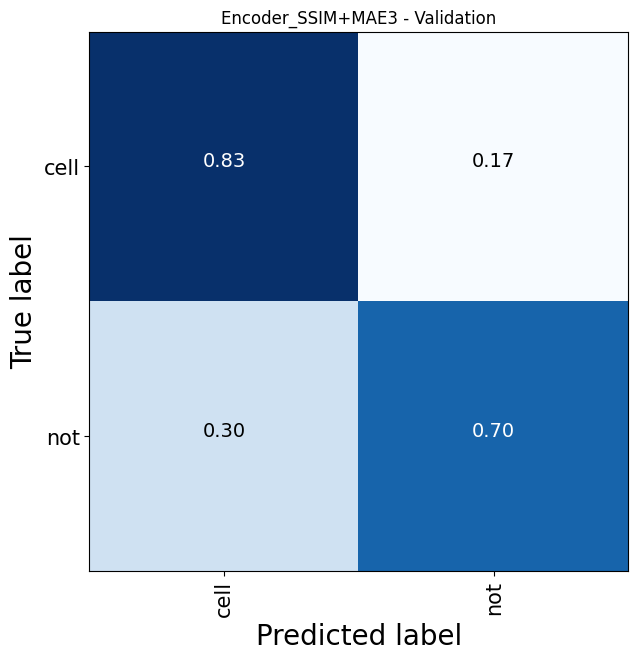

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

2025-05-06 19:05:39.411570: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


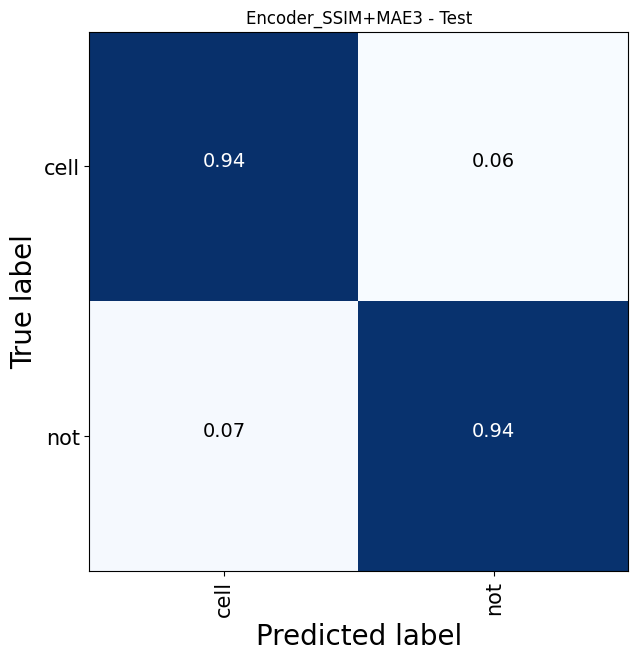

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6439 - loss: 0.6617 - val_accuracy: 0.7527 - val_loss: 0.5226
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7426 - loss: 0.5272 - val_accuracy: 0.7563 - val_loss: 0.5060
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7503 - loss: 0.5167 - val_accuracy: 0.7593 - val_loss: 0.4965
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7576 - loss: 0.5085 - val_accuracy: 0.7656 - val_loss: 0.4910
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7622 - loss: 0.5018 - val_accuracy: 0.7669 - val_loss: 0.4876
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7586 - loss: 0.5032 - val_accuracy: 0.7680 - val_loss: 0.4848
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7635 - loss: 0.4987 - val_accuracy: 0.7690 - val_loss: 0.4826
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7618 - loss: 0.4936 - val_accuracy: 0.

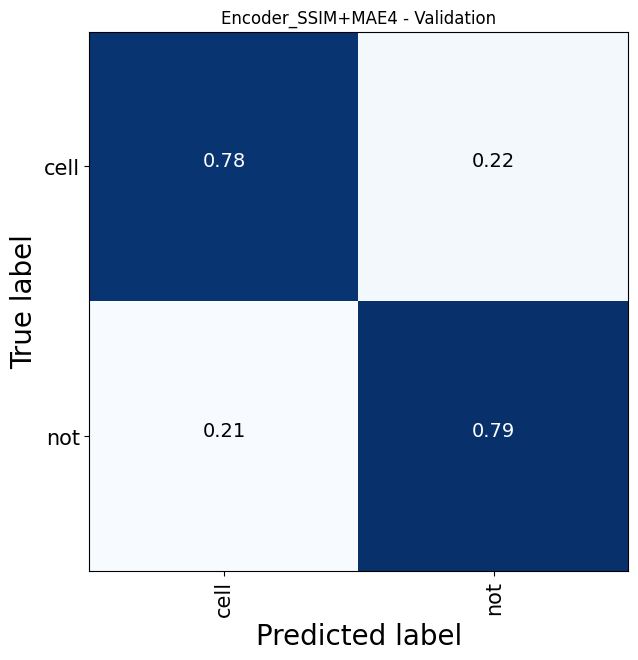

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

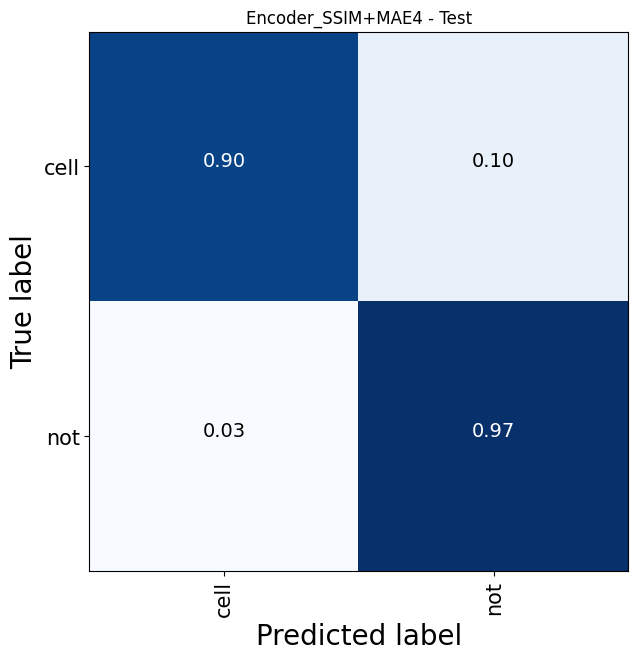

In [9]:
train_generator,validation_generator,test_generator=data_gen()
stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=2,
)

param_grid = {
    'dropout_rate': [0.3, 0.5],
    'l2_reg': [1e-3, 0.01],
}
combinations = list(product(*param_grid.values()))
combinations.append((0.0, 0.0))

for i, params in enumerate(combinations):

  encoder_name="Encoder_SSIM+MAE"+str(i)
  encoder= keras.saving.load_model(ENCODER_PATH)
  model = get_model(encoder,TRAIN_ENCODER,SHAPE,params[0],params[1])
  model.compile(keras.optimizers.Adam(
    #  1e-4
      ),
      loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
      )


  model.fit(train_generator,
          epochs=50,
          validation_data = validation_generator,
          callbacks=[ stopping],
          )
  
  os.makedirs(MODEL_PATH, exist_ok=True)
  model.save(os.path.join(MODEL_PATH, f'supervised_{encoder_name}.keras'))
  print()
  print(params)
  print()
  plot_conf_matrix(model, validation_generator, f'{encoder_name} - Validation')
  plot_conf_matrix(model, test_generator, f'{encoder_name} - Test')



In [10]:
import pandas as pd

results_df = pd.DataFrame(results)

os.makedirs(RESULTS_PATH, exist_ok=True)
results_df.to_excel(RESULT_PATH)

print(results_df)


                            Model  Accuracy    Recall  Precision  Specificity
0  Encoder_SSIM+MAE0 - Validation  0.771104  0.802693   0.739683     0.742286
1        Encoder_SSIM+MAE0 - Test  0.945500  0.934000   0.955988     0.957000
2  Encoder_SSIM+MAE1 - Validation  0.766024  0.821798   0.724662     0.715143
3        Encoder_SSIM+MAE1 - Test  0.946500  0.943000   0.949648     0.950000
4  Encoder_SSIM+MAE2 - Validation  0.757807  0.826809   0.711974     0.694857
5        Encoder_SSIM+MAE2 - Test  0.939000  0.935000   0.942540     0.943000
6  Encoder_SSIM+MAE3 - Validation  0.759301  0.829001   0.713093     0.695714
7        Encoder_SSIM+MAE3 - Test  0.939500  0.944000   0.935580     0.935000
8  Encoder_SSIM+MAE4 - Validation  0.783953  0.778578   0.770853     0.788857
9        Encoder_SSIM+MAE4 - Test  0.933500  0.898000   0.966631     0.969000
